# Sentiment Analysis on News (Telegram Bot)

## Overview

News sentiment analysis has now become one of the most interesting and important fields of artificial intelligence. Knowing the sentiments of the market is directly related to predicting its future and can draw a good perspective. In the following, you will learn about the steps of building a Telegram bot, which is responsible for analyzing the sentiments of news related to the Bitcoin cryptocurrency.

## Step 1: Install needed tools

In [ ]:
pip install requests logging

In [ ]:
pip install python-telegram-bot

In [ ]:
pip install textblob

In [ ]:
pip install nest_asyncio

## Step 2: Get API Token and Key

To build a Telegram bot, you need 2 important API tools.
1. First of all, you need to get the Telegram token from Botfather's Telegram bot so that you can create your own Telegram bot on it.
2. In the second step, you need to get an API key from a news website so that you can call and receive the daily news from it.

## Step 3: Read the API Documentation

To understand how to use the key and receive news from the source, you should read the relevant information from its documentation.

## Step 4: Choose Pre_Train Model

One of the most key and important parts is using a pre-trained model to analyze market sentiment. Analyzing emotions in its normal state is different and only sees emotions from the perspective of being positive or negative. Meanwhile, in the fine-tuned model for the market, sentiment analysis examines everything from a buy or sell perspective.

**Notice: In this bot, we used a model from Hugging Face.**

## Step 5: Make sample bot

In the first step of building the bot in practical form, we use the textblob library to provide a simple sentiment analysis based solely on whether the news is positive or negative.

In [ ]:
import logging
import requests
import nest_asyncio
from textblob import TextBlob
from telegram import Update
from telegram.ext import Application, CommandHandler, CallbackContext

# Telegram Bot Token (Replace with your own bot token from BotFather)
TELEGRAM_API_TOKEN = '7982112...............'

# News API Key (Replace with your own NewsAPI key)
NEWS_API_KEY = '3537a3f..................'

nest_asyncio.apply()

# Set up logging to track errors and debug information
logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
                    level=logging.INFO)
logger = logging.getLogger(__name__)

# Fetch Bitcoin news using NewsAPI
def fetch_bitcoin_news():
    url = f'https://newsapi.org/v2/everything?q=bitcoin&apiKey={NEWS_API_KEY}'
    response = requests.get(url)
    data = response.json()

    if response.status_code == 200 and 'articles' in data:
        return data['articles']
    else:
        return []

# Sentiment analysis function using TextBlob
def analyze_sentiment(text: str) -> str:
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity

    # Determine sentiment label based on polarity
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"

# Command handler for '/start' command
async def start(update: Update, context: CallbackContext) -> None:
    await update.message.reply_text(
        "Hi! I am your Bitcoin News and Sentiment bot. Type /bitcoin to get the latest Bitcoin news and sentiment analysis."
    )

# Command handler for '/bitcoin' to get Bitcoin news and sentiment analysis
async def bitcoin(update: Update, context: CallbackContext) -> None:
    # Fetch the latest Bitcoin news
    articles = fetch_bitcoin_news()
    if not articles:
        await update.message.reply_text("Sorry, I couldn't fetch the news at the moment. Please try again later.")
        return

    # Analyze sentiment for each article
    response_text = "Latest Bitcoin News and Sentiment Analysis:\n\n"
    for article in articles[:5]:  # Limit to first 5 articles
        title = article['title']
        description = article['description']
        sentiment = analyze_sentiment(description or title)

        response_text += f"Title: {title}\nSentiment: {sentiment}\n\n"

    await update.message.reply_text(response_text)

# Command handler for '/help' to explain the bot's functionality
async def help(update: Update, context: CallbackContext) -> None:
    await update.message.reply_text(
        "Use the following commands:\n"
        "/start - Start the bot\n"
        "/bitcoin - Get the latest Bitcoin news and sentiment analysis"
    )

# Error handler to log any exceptions
def error(update: Update, context: CallbackContext) -> None:
    logger.warning(f'Update {update} caused error {context.error}')

# Main function to set up and start the bot
def main():
    # Set up the Application
    application = Application.builder().token(TELEGRAM_API_TOKEN).build()

    # Register command handlers
    application.add_handler(CommandHandler("start", start))
    application.add_handler(CommandHandler("bitcoin", bitcoin))
    application.add_handler(CommandHandler("help", help))

    # Log all errors
    application.add_error_handler(error)

    # Start polling for messages
    application.run_polling()

if __name__ == '__main__':
    main()


**This cannot be a logical way to analyze market sentiment. The market has its own rules and it should be done based on keywords and its semantic load.**

## Step 6: Make the standard bot

Now it's time to use the pre-trained models for sentiment analysis that were selected in step 4.

In [ ]:
import logging
import requests
from telegram import Update
from telegram.ext import Application, CommandHandler, CallbackContext
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch

# Telegram Bot Token (Replace with your own bot token from BotFather)
TELEGRAM_API_TOKEN = '798211....................'

# News API Key (Replace with your own NewsAPI key)
NEWS_API_KEY = '3537a3f..............'

# Set up logging to track errors and debug information
logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
                    level=logging.INFO)
logger = logging.getLogger(__name__)

# Using the HuggingFace pipeline for sentiment analysis
pipe = pipeline("text-classification", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

# Alternatively, loading the model and tokenizer directly
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

# Fetch Bitcoin news using NewsAPI
def fetch_bitcoin_news():
    url = f'https://newsapi.org/v2/everything?q=bitcoin&apiKey={NEWS_API_KEY}'
    response = requests.get(url)
    data = response.json()

    if response.status_code == 200 and 'articles' in data:
        return data['articles']
    else:
        return []

# Sentiment analysis function using the HuggingFace pipeline (high-level)
def analyze_sentiment_pipeline(text: str) -> str:
    result = pipe(text)
    label = result[0]['label']  # 'LABEL_0' -> Negative, 'LABEL_1' -> Neutral, 'LABEL_2' -> Positive
    return label

# Sentiment analysis function using manual tokenization and model inference (low-level)
def analyze_sentiment_manual(text: str) -> str:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=-1).item()

    if predicted_class == 0:
        return "Sell mode (Negative)"
    elif predicted_class == 1:
        return "Risk mode(Neutral)"
    else:
        return "Buy mode (Positive)"

# Command handler for '/start' command
async def start(update: Update, context: CallbackContext) -> None:
    await update.message.reply_text(
        "Hi! I am your Bitcoin News and Sentiment bot. Type /bitcoin to get the latest Bitcoin news and sentiment analysis."
    )

# Command handler for '/bitcoin' to get Bitcoin news and sentiment analysis
async def bitcoin(update: Update, context: CallbackContext) -> None:
    # Fetch the latest Bitcoin news
    articles = fetch_bitcoin_news()
    if not articles:
        await update.message.reply_text("Sorry, I couldn't fetch the news at the moment. Please try again later.")
        return

    # Analyze sentiment for each article
    response_text = "Latest Bitcoin News and Sentiment Analysis:\n\n"
    for article in articles[:5]:  # Limit to first 5 articles
        title = article['title']
        description = article['description']

        # Using pipeline approach
        sentiment_pipeline = analyze_sentiment_pipeline(description or title)

        # OR: Use the manual method (uncomment the next line to use manual method instead)
        # sentiment_manual = analyze_sentiment_manual(description or title)

        response_text += f"Title: {title}\nSentiment: {sentiment_pipeline}\n\n"

    await update.message.reply_text(response_text)

# Command handler for '/help' to explain the bot's functionality
async def help(update: Update, context: CallbackContext) -> None:
    await update.message.reply_text(
        "Use the following commands:\n"
        "/start - Start the bot\n"
        "/bitcoin - Get the latest Bitcoin news and sentiment analysis"
    )

# Error handler to log any exception
def error(update: Update, context: CallbackContext) -> None:
    logger.warning(f'Update {update} caused error {context.error}')

# Main function to set up and start the bot
def main():
    # Set up the Application
    application = Application.builder().token(TELEGRAM_API_TOKEN).build()

    # Register command handlers
    application.add_handler(CommandHandler("start", start))
    application.add_handler(CommandHandler("bitcoin", bitcoin))
    application.add_handler(CommandHandler("help", help))

    # Log all errors
    application.add_error_handler(error)

    # Start polling for messages
    application.run_polling()

if __name__ == '__main__':
    main()


## Step 7: Add live price feature

A new feature can be added to the bot that will announce the bitcoin price live to the user. The user can get the price by sending /price.

In [ ]:
import logging
import requests
from telegram import Update
from telegram.ext import Application, CommandHandler, CallbackContext
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
from collections import Counter  # For calculating the most frequent sentiment

# Telegram Bot Token (Replace with your own bot token from BotFather)
TELEGRAM_API_TOKEN = '798211..............'

# News API Key (Replace with your own NewsAPI key)
NEWS_API_KEY = '3537a3f...............'

# Set up logging to track errors and debug information
logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
                    level=logging.INFO)
logger = logging.getLogger(__name__)

# Using the HuggingFace pipeline for sentiment analysis
pipe = pipeline("text-classification", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

# Alternatively, loading the model and tokenizer directly
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

# Fetch Bitcoin price from CoinGecko API
def fetch_bitcoin_price():
    url = "https://api.coingecko.com/api/v3/simple/price?ids=bitcoin&vs_currencies=usd"
    response = requests.get(url)
    data = response.json()

    if 'bitcoin' in data:
        return data['bitcoin']['usd']
    else:
        return None

# Fetch Bitcoin news using NewsAPI
def fetch_bitcoin_news():
    url = f'https://newsapi.org/v2/everything?q=bitcoin&apiKey={NEWS_API_KEY}'
    response = requests.get(url)
    data = response.json()

    if response.status_code == 200 and 'articles' in data:
        return data['articles']
    else:
        return []

# Sentiment analysis function using the HuggingFace pipeline (high-level)
def analyze_sentiment_pipeline(text: str) -> str:
    result = pipe(text)
    label = result[0]['label']  # 'LABEL_0' -> Negative, 'LABEL_1' -> Neutral, 'LABEL_2' -> Positive
    return label

# Sentiment analysis function using manual tokenization and model inference (low-level)
def analyze_sentiment_manual(text: str) -> str:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=-1).item()

    if predicted_class == 0:
        return "Negative"
    elif predicted_class == 1:
        return "Neutral"
    else:
        return "Positive"

# Function to calculate overall sentiment from individual article sentiments
def calculate_overall_sentiment(sentiments):
    # Count the occurrences of each sentiment
    sentiment_counts = Counter(sentiments)

    # Find the most common sentiment
    most_common_sentiment, count = sentiment_counts.most_common(1)[0]

    return most_common_sentiment

# Command handler for '/start' command
async def start(update: Update, context: CallbackContext) -> None:
    await update.message.reply_text(
        "Hi! I am your Bitcoin News and Sentiment bot. Type /bitcoin to get the latest Bitcoin news and sentiment analysis, or /price to get the current Bitcoin price."
    )

# Command handler for '/price' to get current Bitcoin price
async def price(update: Update, context: CallbackContext) -> None:
    price = fetch_bitcoin_price()
    if price:
        await update.message.reply_text(f"The current Bitcoin price is: ${price} USD")
    else:
        await update.message.reply_text("Sorry, I couldn't fetch the current Bitcoin price at the moment. Please try again later.")

# Command handler for '/bitcoin' to get Bitcoin news and sentiment analysis
async def bitcoin(update: Update, context: CallbackContext) -> None:
    # Fetch the latest Bitcoin news
    articles = fetch_bitcoin_news()
    if not articles:
        await update.message.reply_text("Sorry, I couldn't fetch the news at the moment. Please try again later.")
        return

    # Analyze sentiment for each article
    article_sentiments = []
    response_text = "Latest Bitcoin News and Sentiment Analysis:\n\n"
    for article in articles[:5]:  # Limit to first 5 articles
        title = article['title']
        description = article['description']

        # Using pipeline approach
        sentiment_pipeline = analyze_sentiment_pipeline(description or title)
        article_sentiments.append(sentiment_pipeline)

        # OR: Use the manual method (uncomment the next line to use manual method instead)
        # sentiment_manual = analyze_sentiment_manual(description or title)

        response_text += f"Title: {title}\nSentiment: {sentiment_pipeline}\n\n"

    # Calculate overall sentiment
    overall_sentiment = calculate_overall_sentiment(article_sentiments)

    response_text += f"\nOverall Sentiment of Bitcoin News: {overall_sentiment}"

    await update.message.reply_text(response_text)

# Command handler for '/help' to explain the bot's functionality
async def help(update: Update, context: CallbackContext) -> None:
    await update.message.reply_text(
        "Use the following commands:\n"
        "/start - Start the bot\n"
        "/bitcoin - Get the latest Bitcoin news and sentiment analysis\n"
        "/price - Get the current Bitcoin price"
    )

# Error handler to log any exceptions
def error(update: Update, context: CallbackContext) -> None:
    logger.warning(f'Update {update} caused error {context.error}')

# Main function to set up and start the bot
def main():
    # Set up the Application
    application = Application.builder().token(TELEGRAM_API_TOKEN).build()

    # Register command handlers
    application.add_handler(CommandHandler("start", start))
    application.add_handler(CommandHandler("price", price))
    application.add_handler(CommandHandler("bitcoin", bitcoin))
    application.add_handler(CommandHandler("help", help))

    # Log all errors
    application.add_error_handler(error)

    # Start polling for messages
    application.run_polling()

if __name__ == '__main__':
    main()

## Step 8: Make User-friendly UI and use buttons

To make the work look better, we can use a better user design. Buttons do this in the Telegram bot.

Now the Bitcoin news sentiment analyzer bot is ready.

In [ ]:
import logging
import requests
from telegram import Update, InlineKeyboardButton, InlineKeyboardMarkup
from telegram.ext import Application, CommandHandler, CallbackContext, CallbackQueryHandler
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
import nest_asyncio
from collections import Counter  # For calculating the most frequent sentiment

# Telegram Bot Token (Replace with your own bot token from BotFather)
TELEGRAM_API_TOKEN = '737505..............'

# News API Key (Replace with your own NewsAPI key)
NEWS_API_KEY = '3537a3f..............'

nest_asyncio.apply()

# Set up logging to track errors and debug information
logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
                    level=logging.INFO)
logger = logging.getLogger(__name__)

# Using the HuggingFace pipeline for sentiment analysis
pipe = pipeline("text-classification", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

# Alternatively, loading the model and tokenizer directly
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

# Fetch Bitcoin price from CoinGecko API
def fetch_bitcoin_price():
    url = "https://api.coingecko.com/api/v3/simple/price?ids=bitcoin&vs_currencies=usd"
    response = requests.get(url)
    data = response.json()

    if 'bitcoin' in data:
        return data['bitcoin']['usd']
    else:
        return None

# Fetch Bitcoin news using NewsAPI
def fetch_bitcoin_news():
    url = f'https://newsapi.org/v2/everything?q=bitcoin&apiKey={NEWS_API_KEY}'
    response = requests.get(url)
    data = response.json()

    if response.status_code == 200 and 'articles' in data:
        return data['articles']
    else:
        return []

# Sentiment analysis function using the HuggingFace pipeline (high-level)
def analyze_sentiment_pipeline(text: str) -> str:
    result = pipe(text)
    label = result[0]['label']  # 'LABEL_0' -> Negative, 'LABEL_1' -> Neutral, 'LABEL_2' -> Positive
    return label

# Sentiment analysis function using manual tokenization and model inference (low-level)
def analyze_sentiment_manual(text: str) -> str:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=-1).item()

    if predicted_class == 0:
        return "Negative"
    elif predicted_class == 1:
        return "Neutral"
    else:
        return "Positive"

# Function to calculate overall sentiment from individual article sentiments
def calculate_overall_sentiment(sentiments):
    # Count the occurrences of each sentiment
    sentiment_counts = Counter(sentiments)

    # Find the most common sentiment
    most_common_sentiment, count = sentiment_counts.most_common(1)[0]

    return most_common_sentiment

# Start menu buttons
def start_menu() -> InlineKeyboardMarkup:
    keyboard = [
        [InlineKeyboardButton("Get Bitcoin News", callback_data='bitcoin')],
        [InlineKeyboardButton("Get Bitcoin Price", callback_data='price')],
        [InlineKeyboardButton("Help", callback_data='help')]
    ]
    return InlineKeyboardMarkup(keyboard)

# Command handler for '/start' command
async def start(update: Update, context: CallbackContext) -> None:
    await update.message.reply_text(
        "Welcome to the Bitcoin News and Sentiment Bot!\n"
        "Select an option below:",
        reply_markup=start_menu()  # Display the inline keyboard here
    )

# Command handler for '/price' to get current Bitcoin price
async def price(update: Update, context: CallbackContext) -> None:
    price = fetch_bitcoin_price()
    if price:
        await update.callback_query.edit_message_text(f"The current Bitcoin price is: ${price} USD")
    else:
        await update.callback_query.edit_message_text("Sorry, I couldn't fetch the current Bitcoin price at the moment. Please try again later.")

# Command handler for '/bitcoin' to get Bitcoin news and sentiment analysis
async def bitcoin(update: Update, context: CallbackContext) -> None:
    # Fetch the latest Bitcoin news
    articles = fetch_bitcoin_news()
    if not articles:
        await update.callback_query.edit_message_text("Sorry, I couldn't fetch the news at the moment. Please try again later.")
        return

    # Analyze sentiment for each article
    article_sentiments = []
    response_text = "Latest Bitcoin News and Sentiment Analysis:\n\n"
    for article in articles[:5]:  # Limit to first 5 articles
        title = article['title']
        description = article['description']

        # Using pipeline approach
        sentiment_pipeline = analyze_sentiment_pipeline(description or title)
        article_sentiments.append(sentiment_pipeline)

        # OR: Use the manual method (uncomment the next line to use manual method instead)
        # sentiment_manual = analyze_sentiment_manual(description or title)

        response_text += f"Title: {title}\nSentiment: {sentiment_pipeline}\n\n"

    # Calculate overall sentiment
    overall_sentiment = calculate_overall_sentiment(article_sentiments)

    response_text += f"\nOverall Sentiment of Bitcoin News: {overall_sentiment}"

    await update.callback_query.edit_message_text(response_text)

# Command handler for '/help' to explain the bot's functionality
async def help(update: Update, context: CallbackContext) -> None:
    await update.callback_query.edit_message_text(
        "Welcome! Here's what I can do:\n\n"
        "1. Get Bitcoin News and Sentiment: Click 'Get Bitcoin News' to see the latest Bitcoin news and sentiment analysis.\n"
        "2. Get Bitcoin Price: Click 'Get Bitcoin Price' to check the current Bitcoin price.\n"
        "3. Help: Click 'Help' to see this message again."
    )

# Handler for inline button responses
async def button_handler(update: Update, context: CallbackContext) -> None:
    query = update.callback_query
    data = query.data

    if data == 'bitcoin':
        await bitcoin(update, context)
    elif data == 'price':
        await price(update, context)
    elif data == 'help':
        await help(update, context)

# Error handler to log any exceptions
def error(update: Update, context: CallbackContext) -> None:
    logger.warning(f'Update {update} caused error {context.error}')

# Main function to set up and start the bot
def main():
    # Set up the Application
    application = Application.builder().token(TELEGRAM_API_TOKEN).build()

    # Register command handlers
    application.add_handler(CommandHandler("start", start))
    application.add_handler(CallbackQueryHandler(button_handler))  # Handle button presses

    # Log all errors
    application.add_error_handler(error)

    # Start polling for messages
    application.run_polling()

if __name__ == '__main__':
    main()


## Outputs:

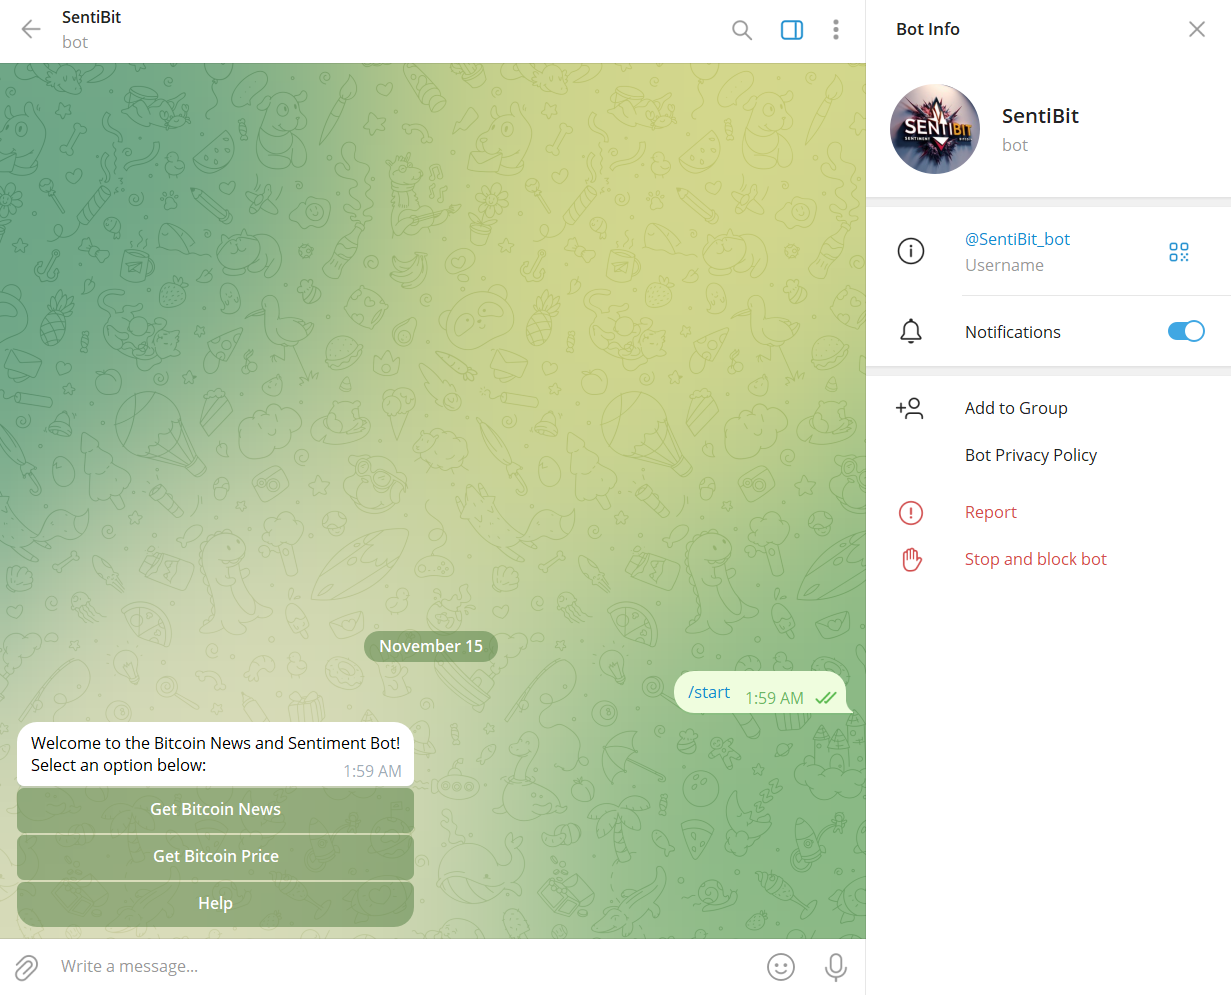

**Click Start and show Menu**



---



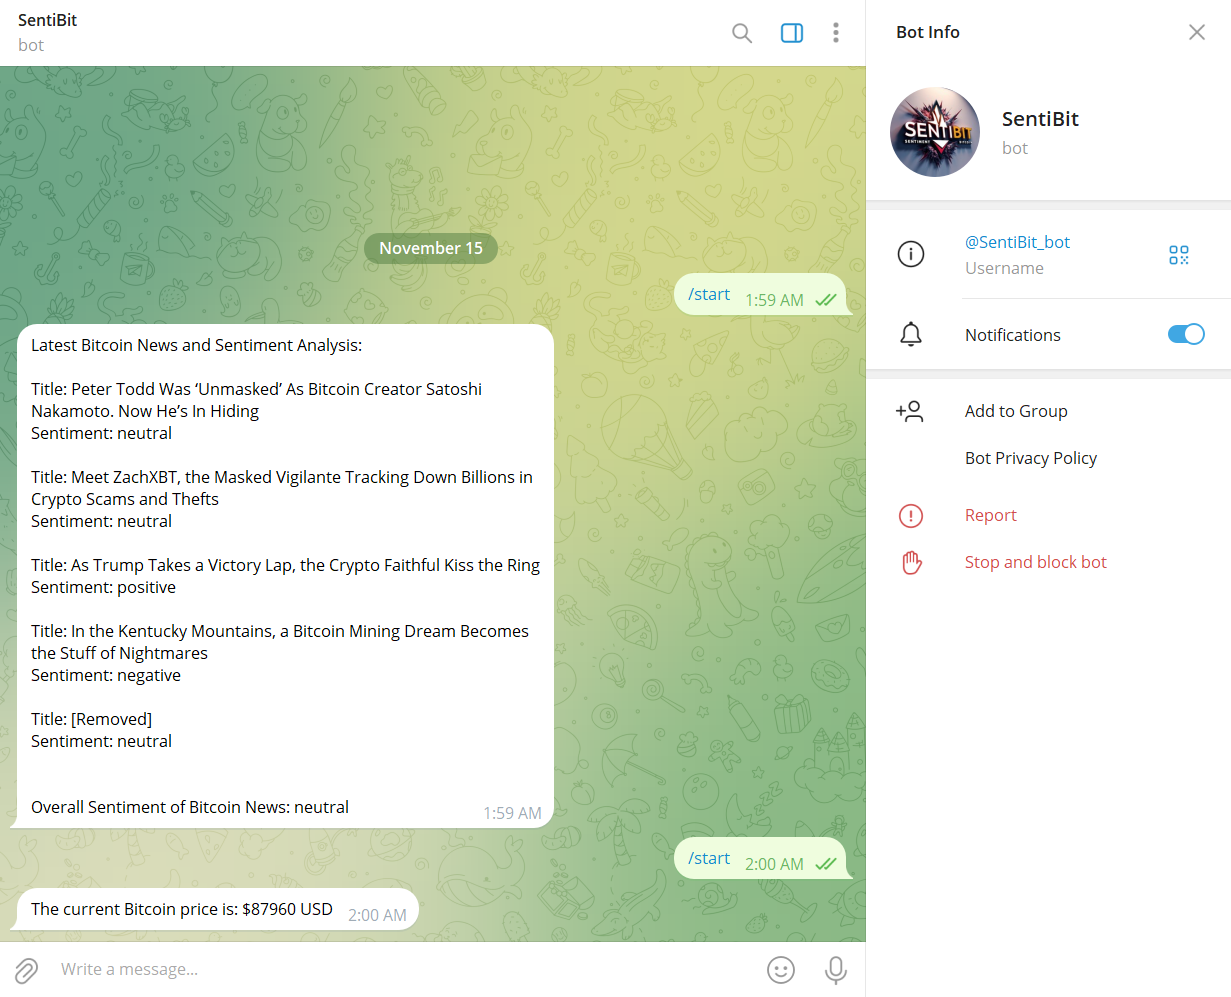

**Sentiment Analysis and Live Price**